# In this notebook transfer learning will be employed to build a classifier that predicts whether a given image contains an alpaca or not.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
# load the images from directory
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training',
    seed=42
)
validation_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


['alpaca', 'not alpaca']


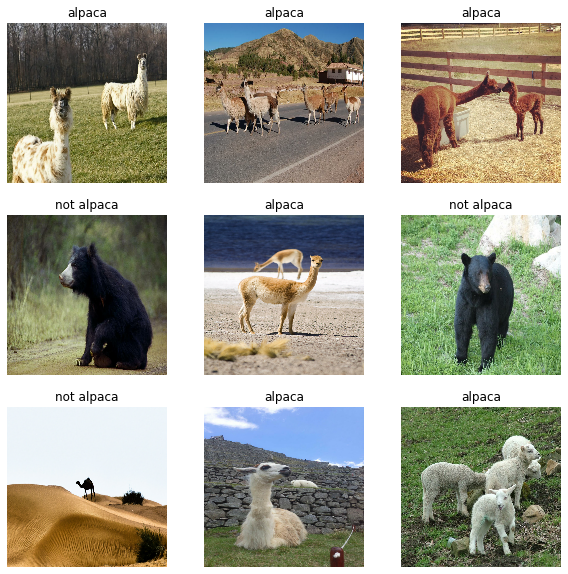

In [3]:
# lets get a feel for the images we are dealing with.
# as it happens, some of the images are mislabeled

class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

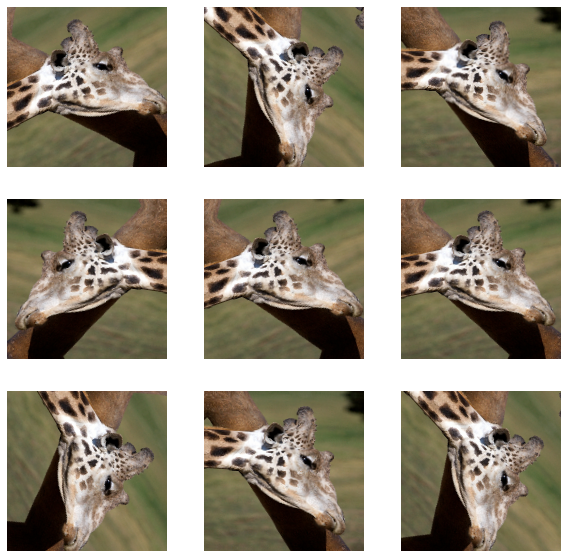

In [4]:
# since we do not have a very large dataset to work with it is a good idea to preprocess and augment the training data
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)


def data_augmenter():
    """
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    """
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation


data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Useful to remember
* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give the model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [5]:
# means of preprocessing the input
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### What makes MobileNet useful is the relatively low computational cost of training and making predictions. MobileNet achieves this via a different way of performing convolutions. Namely, in stead of a volume based filter, we use a so called "depth wise" filter, followed by a point wise filter to achieve the same output dimension. The result is roughly ten times less computations required for a single layer with minimal impact on performance.

|<img src="mobilenet.png" alt="Mobilenet Block" width="1200"/>|
|:--:|
| *Block Architecture for the MobileNet Depth-Wise Convolutions* |

More info on MobileNet can be found here: <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html">Google AI Blog</a>

In [6]:
# download and establish the base model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=True,
    weights='imagenet'
)

In [7]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [8]:
# lets check out the last two layers
# these layers will eventually be frozen and retrained
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [9]:
# lets predict on a batch of images just to see what happens
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(label_batch)

tf.Tensor([1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0], shape=(32,), dtype=int32)


In [10]:
# definitely not alpacas
# remember MobileNet has been trained to predict over the ImageNet data so we should not expect to get it right the first time
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.42582163),
  ('n02708093', 'analog_clock', 0.092755675)],
 [('n04589890', 'window_screen', 0.23985949),
  ('n03887697', 'paper_towel', 0.14802647)],
 [('n04589890', 'window_screen', 0.7449458),
  ('n03598930', 'jigsaw_puzzle', 0.021948548)],
 [('n04589890', 'window_screen', 0.3354601),
  ('n03530642', 'honeycomb', 0.07628973)],
 [('n04589890', 'window_screen', 0.2732742),
  ('n03733281', 'maze', 0.08846931)],
 [('n04589890', 'window_screen', 0.6745238),
  ('n03530642', 'honeycomb', 0.07659913)],
 [('n04589890', 'window_screen', 0.7912856),
  ('n04209239', 'shower_curtain', 0.09241599)],
 [('n04589890', 'window_screen', 0.16462995),
  ('n03598930', 'jigsaw_puzzle', 0.08749132)],
 [('n03598930', 'jigsaw_puzzle', 0.37021282),
  ('n04589890', 'window_screen', 0.099569514)],
 [('n04589890', 'window_screen', 0.61616504),
  ('n03887697', 'paper_towel', 0.054876436)],
 [('n03530642', 'honeycomb', 0.25448844),
  ('n04589890', 'window_screen', 0.24874298)],
 [(

In [11]:
# freezing the layers for the "alpaca_model"
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    """
    Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    """

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,  # <== Important!!!!
        weights="imagenet"
    )

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)

    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1, activation="linear")(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [12]:
# create and train the model

alpaca_classifier = alpaca_model(IMG_SIZE, data_augmentation)

base_learning_rate = 0.001
alpaca_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

initial_epochs = 5
history = alpaca_classifier.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

C:\Development\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
9/9 [==============================] - 5s 326ms/step - loss: 0.7885 - accuracy: 0.5038 - val_loss: 0.6513 - val_accuracy: 0.5692
Epoch 2/5
9/9 [==============================] - 3s 308ms/step - loss: 0.6579 - accuracy: 0.5687 - val_loss: 0.4719 - val_accuracy: 0.7231
Epoch 3/5
9/9 [==============================] - 3s 290ms/step - loss: 0.5068 - accuracy: 0.7595 - val_loss: 0.3999 - val_accuracy: 0.7846
Epoch 4/5
9/9 [==============================] - 3s 249ms/step - loss: 0.4527 - accuracy: 0.7366 - val_loss: 0.4048 - val_accuracy: 0.7231
Epoch 5/5
9/9 [==============================] - 3s 270ms/step - loss: 0.3962 - accuracy: 0.7977 - val_loss: 0.3227 - val_accuracy: 0.8462


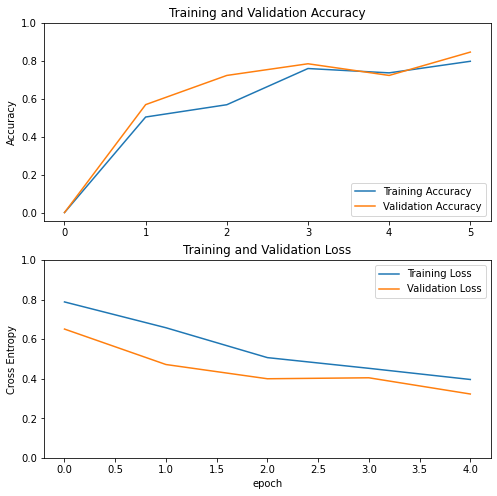

In [13]:
# plot some of the relevant metrics
# the performance is ok, but not great, we can definitely do better

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
# fine tuning the model

base_model = alpaca_classifier.layers[4]
base_model.trainable = True
# lets take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# fine-tune from this layer onwards
fine_tune_at = 120

# freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# define a BinaryCrossentropy loss function.
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr=0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics = ["accuracy"]

alpaca_classifier.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=metrics
)

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = alpaca_classifier.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset
)

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Number of layers in the base model:  154
Epoch 5/10
9/9 [==============================] - 6s 371ms/step - loss: 0.6010 - accuracy: 0.7176 - val_loss: 0.3061 - val_accuracy: 0.9231
Epoch 6/10
9/9 [==============================] - 3s 354ms/step - loss: 0.3425 - accuracy: 0.8206 - val_loss: 0.1819 - val_accuracy: 0.9231
Epoch 7/10
9/9 [==============================] - 4s 366ms/step - loss: 0.2726 - accuracy: 0.8855 - val_loss: 0.1680 - val_accuracy: 0.8923
Epoch 8/10
9/9 [==============================] - 3s 326ms/step - loss: 0.2096 - accuracy: 0.9351 - val_loss: 0.1185 - val_accuracy: 0.9538
Epoch 9/10
9/9 [==============================] - 3s 338ms/step - loss: 0.1582 - accuracy: 0.9351 - val_loss: 0.0925 - val_accuracy: 0.9692
Epoch 10/10
9/9 [==============================] - 3s 345ms/step - loss: 0.1387 - accuracy: 0.9504 - val_loss: 0.0941 - val_accuracy: 0.9538


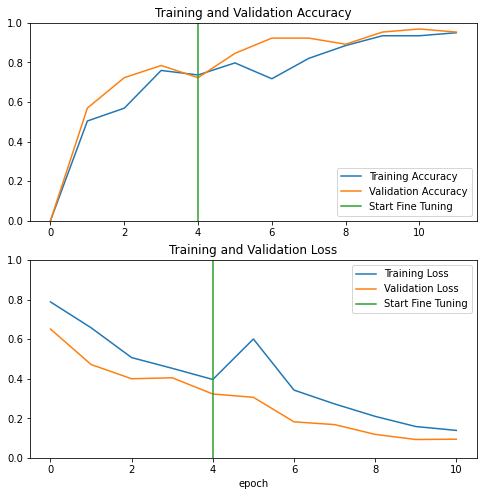

In [15]:
# this looks much better

# these models are also very quick to train so iterating and further fine tuning for even better performance is very much in reach

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()